<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# CIEM5110-2 Workshop 8.1: Hammer test

## Preliminaries

In [1]:
import sys
import numpy as np
sys.path.append('../../')

import utils.proputils as pu
import main

from matplotlib import pyplot as plt
from names import GlobNames as gn

%matplotlib widget

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lkehcx2p because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Compute natural frequencies, compare with experiments

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file rail.geom ...
InitModule: Creating node groups...
InitModule: Created group left with nodes [0]
InitModule: Created group right with nodes [1]
InitModule: Created group all with nodes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
InitModule: Creating model...
Creating Line2Shape...
Running chain...
ModeShapeModule: running eigenvalue problem...
No Dirichlet BCs, three rigid body modes will be found
ModeShapeModule: smallest natural frequency  2.0227e-04 rad / s


/opt/conda/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


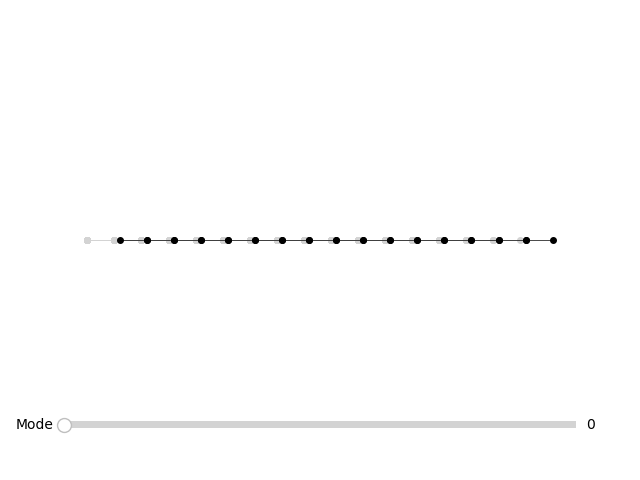

End of execution
[3.21924011e-05+0.00000000e+00j 0.00000000e+00+4.09133976e-05j
 5.84385682e-05+0.00000000e+00j 1.00683186e+02+0.00000000e+00j
 2.79823436e+02+0.00000000e+00j 5.55998659e+02+0.00000000e+00j
 7.96083998e+02+0.00000000e+00j 9.37406809e+02+0.00000000e+00j
 1.43880522e+03+0.00000000e+00j 1.60776420e+03+0.00000000e+00j
 2.08306687e+03+0.00000000e+00j 2.45188344e+03+0.00000000e+00j
 2.90530610e+03+0.00000000e+00j 3.34799564e+03+0.00000000e+00j
 3.95931287e+03+0.00000000e+00j 4.32033403e+03+0.00000000e+00j
 5.32713886e+03+0.00000000e+00j 5.40073857e+03+0.00000000e+00j
 6.63336322e+03+0.00000000e+00j 7.12726702e+03+0.00000000e+00j
 8.08277647e+03+0.00000000e+00j 9.45964601e+03+0.00000000e+00j
 9.84889162e+03+0.00000000e+00j 1.10097604e+04+0.00000000e+00j
 1.11641239e+04+0.00000000e+00j 1.13049011e+04+0.00000000e+00j
 1.17487663e+04+0.00000000e+00j 1.18400115e+04+0.00000000e+00j
 1.20967298e+04+0.00000000e+00j 1.26597978e+04+0.00000000e+00j
 1.27586098e+04+0.00000000e+00j 1.4031

In [2]:
E = 210e9
rho = 7850
L = 3.259
I = 2337.9e-8
Area = 69.77e-4

nu = 0.3 # assumed

props = pu.parse_file('beam.pro')

props['init']['mesh']['file'] = 'rail.geom'

props['model']['frame']['EA'] = E*Area
props['model']['frame']['GAs'] = 5/6 * E/2/(1-nu) * Area
props['model']['frame']['EI'] = E*I
props['model']['frame']['rhoA'] = rho * Area
props['model']['frame']['rhoI'] = rho * I

props['stepper']['type'] = 'ModeShape'
props['model']['models'] = '[frame]'

props['frameview'] = {}
props['frameview']['type'] = 'FrameView'
props['frameview']['deform'] = 1
props['frameview']['label'] = 'Mode'
props['frameview']['plotDirichlet'] = 'False'
props['frameview']['plotNeumann'] = 'False'

del props['lodi']

globdat = main.jive(props)
print(globdat[gn.EIGENFREQS]/2/np.pi)

## Generate a force signal

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the .csv file and store the data in a data frame. Use 'sep' argument to define the column separators, 'skiprows' to skip the first four rows, 'decimal' to define the decimal separator. 
data_pos35_df = pd.read_csv("example_pos35.csv",sep = ";",skiprows = 4, decimal = ",")
data_pos35 = data_pos35_df.to_numpy()

# Define a trigger force of 5 N
force_trigger = 5

# Get the boolean indices of the forces that are larger than the trigger force
idx_boolean = data_pos35[:,1] > force_trigger

# Find the indices of triggered forces
idx_triggered = np.where(idx_boolean)[0]

# Define a rectangular window
rec_win = np.zeros(len(data_pos35[:,1]))
rec_win[idx_triggered,] = 1
f_max_windowed = np.multiply(data_pos35[:,1], rec_win)

# Truncate the signal 10 samples before the first index of the triggered force
f_max_truncated = f_max_windowed[idx_triggered[0]-10:,]
acc_max_truncated = data_pos35[idx_triggered[0]-10:,5]

# Truncate the end of the time series
maxstep = 20000

f_max_truncated = f_max_truncated[:maxstep]
acc_max_truncated = acc_max_truncated[:maxstep]

# Get delta time
dt = data_pos35[1,0]-data_pos35[0,0]

# Write force signal to a file
np.savetxt('signal.dat',f_max_truncated)

## Implicit dynamics simulation

In [4]:
props = pu.parse_file('beam.pro')

props['init']['mesh']['file'] = 'rail.geom'
props['init']['nodeGroups'] = '[right,mid]'
props['init']['mid'] = {}
props['init']['mid']['xtype'] = 'mid'

props['model']['models'] = '[frame, neum]'

props['model']['neum']['groups'] = '[right]'
props['model']['neum']['dofs'] = '[dy]'
props['model']['neum']['values'] = '[-1]'
props['model']['neum']['timeSignal'] = 'signal.dat'

props['model']['frame']['EA'] = E*Area
props['model']['frame']['GAs'] = 5/6 * E/2/(1-nu) * Area
props['model']['frame']['EI'] = E*I
props['model']['frame']['rhoA'] = rho * Area
props['model']['frame']['rhoI'] = rho * I

props['stepper']['deltaTime'] = dt
props['stepper']['nsteps'] = maxstep
props['stepper']['gamma'] = 0.501
props['stepper']['beta'] = 0.26

props['accel'] = {}
props['accel']['type'] = 'Acceleration'
props['accel']['groups'] = '[mid]'

del props['frameview']
del props['lodi']

globdat = main.jive(props)

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file rail.geom ...
InitModule: Creating node groups...
InitModule: Created group right with nodes [1]
InitModule: Created group mid with nodes [9]
InitModule: Creating model...
Creating Line2Shape...
Running chain...
Running time step 0
Running time step 200
Running time step 400
Running time step 600
Running time step 800
Running time step 1000
Running time step 1200
Running time step 1400
Running time step 1600
Running time step 1800
Running time step 2000
Running time step 2200
Running time step 2400
Running time step 2600
Running time step 2800
Running time step 3000
Running time step 3200
Running time step 3400
Running time step 3600
Running time step 3800
Running time step 4000
Running time step 4200
Running time step 4400
Running time step 4600
Running time step 4800
Running time step 5000
Running time step 5200
Running time step 5400
Running time step 5600
Running time step 5800
Running t

## Plot accelerations, compare with experiments

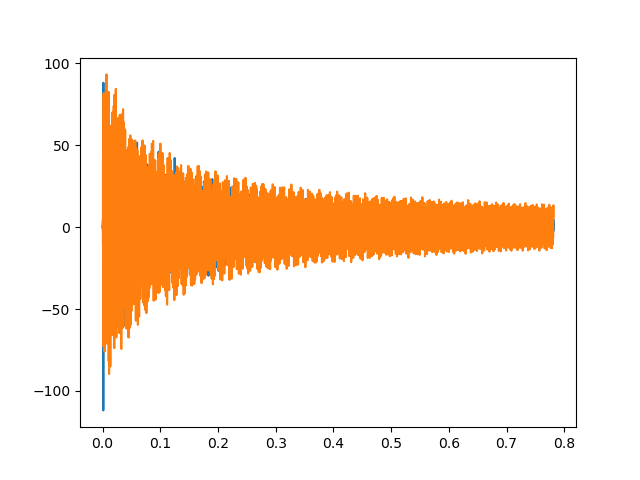

In [5]:
time = np.linspace(0,maxstep*dt,maxstep)

accel_mid = globdat['accel']['mid']['accel']['dy']

plt.figure()

plt.plot(time,9.81*acc_max_truncated)
plt.plot(time,accel_mid)
plt.show()